<a href="https://colab.research.google.com/github/nicktho16/CS420Assignments/blob/main/FrozenLakeProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import matplotlib.pyplot as plt

# Suppress all DeprecationWarnings globally
#You can safely ignore warnings. This code helps supress some
warnings.simplefilter("ignore", DeprecationWarning)


In [5]:
# Define the custom 8x8 map
custom_map = [
    "SFFFFHFF",
    "FFFFFFFF",
    "FFFFFHFF",
    "FFFFFFFF",
    "HHHFFHHH",
    "FFFFFFFF",
    "FHFFFFFF",
    "FHFFFFFG"
]

# Create the environment with the custom 8x8 map
env = gym.make('FrozenLake-v1', desc=custom_map, is_slippery=True, new_step_api=True)

# Print the number of states and actions
n_states = env.observation_space.n
n_actions = env.action_space.n

In [6]:
gamma = 0.9
theta = 1e-6
V = np.zeros(n_states)
policy = np.zeros(n_states, dtype=int)

The discount factor (gamma) determines the importance of future rewards compared to immediate rewards. As gamma gets higher, the agent values future rewards almost as much as immediate rewards, so the agent will be more inclined to explore the grid and plan for long-term gains. In this case with gamma = 0.9, this indicates that the agent gives significant weight to future rewards but not as much as he does to immediate rewards since gamma doesnt equal 1.

In [7]:
def value_iteration():
    global V, policy
    while True:
        delta = 0
        new_V = np.copy(V)
        for s in range(n_states):
            q_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                    if done:
                        q_values[a] += prob * reward
                    else:
                        q_values[a] += prob * (reward + gamma * V[next_state])
            new_V[s] = max(q_values)
            delta = max(delta, abs(V[s] - new_V[s]))
            policy[s] = np.argmax(q_values)
        V = new_V
        if delta < theta:
            break

def extract_policy():
    for s in range(n_states):
        q_values = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                if done:
                    q_values[a] += prob * reward
                else:
                    q_values[a] += prob * (reward + gamma * V[next_state])
        policy[s] = np.argmax(q_values)

def display_policy():
    actions = ['←', '↓', '→', '↑']
    grid_size = int(np.sqrt(n_states))

    lake_map = env.unwrapped.desc

    print("\nOptimal Policy:\n")
    for i in range(grid_size):
        row = ""
        for j in range(grid_size):
            state = i * grid_size + j
            tile = lake_map[i, j].decode("utf-8")

            if tile == 'H':
                cell = 'H'  # Hole
            elif tile == 'G':
                cell = 'G'  # Goal
            elif tile == 'S':
                cell = 'S'  # Start position
            else:
                cell = actions[policy[state]]
            row += f"| {cell} "
        row += "|"
        print(row)
        print("-" * (grid_size * 4 + 1))

value_iteration()
extract_policy()
display_policy()


Optimal Policy:

| S | → | → | → | ← | H | → | ← |
---------------------------------
| ↓ | → | → | ↓ | ← | ↓ | ↓ | ↓ |
---------------------------------
| ↓ | → | → | ↓ | ← | H | → | ↓ |
---------------------------------
| ↑ | ↑ | ↑ | → | ← | ↓ | ↑ | ↑ |
---------------------------------
| H | H | H | → | ← | H | H | H |
---------------------------------
| ↓ | ↓ | ↓ | → | ↓ | ↓ | ↓ | ↓ |
---------------------------------
| ← | H | → | → | → | → | ↓ | ↓ |
---------------------------------
| ← | H | → | → | → | → | → | G |
---------------------------------


The state-value function is represented here by V, which is the variable that stores the value of each state. It represents the expected discounted reward when starting from state s and following the optimal policy pi. It is iteratively updated using the Bellman Update Equation in the value_iteration() function until V is smaller than theta.

The Bellman Equation occurs in this code block, with the value_iteration() function

In [8]:
# Function to run multiple episodes and compute average reward and steps
def run_experiment(policy, env, num_episodes=1000):
    rewards = []
    steps = []
    for _ in range(num_episodes):
        # Reset the environment (new API returns observation and info)
        # The updated reset() method returns observation only
        obs = env.reset()
        total_reward = 0
        step_count = 0
        done = False
        while not done:
            # Choose the action from the computed policy
            action = policy[obs]
            # Perform the action; new API returns (obs, reward, terminated, truncated, info)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            step_count += 1
        rewards.append(total_reward)
        steps.append(step_count)

    avg_reward = np.mean(rewards)
    avg_steps = np.mean(steps)
    print(f"\nAfter {num_episodes} episodes:")
    print(f"Average reward: {avg_reward}")
    print(f"Average number of steps per episode: {avg_steps}")
    return avg_reward, avg_steps


This code block simulates many different experiments of the frozen lake and collects data on how well the agent performs by taking their average rewards and steps, then it returns these stats which truly evaluates the agents performance.

In [9]:
# Run the experiment
run_experiment(policy, env, num_episodes=1000)

# Reset the environment
env.reset()
returns = []


After 1000 episodes:
Average reward: 0.784
Average number of steps per episode: 66.501


**Conclusion Block**

What is the transition probability matrix for this environment? - Since is_slippery = true, the agent will move in intended direction with probability of 1/3, or else will move in either perpendicular direction with equal probability of 1/3 in both directions

How are rewards determined in FrozenLake? - Agent starts with 0 points at (0,0),If the agent reaches the goal, they get 1 point. Falling into a hole or moving to a frozen spot gives 0 points.

For your modified 8x8 environment, estimate the probability that the agent reaches the goal. - Between .7 and .9, randomness plays a factor due to is_slippery being true so it isn't possible to estimate an exact number

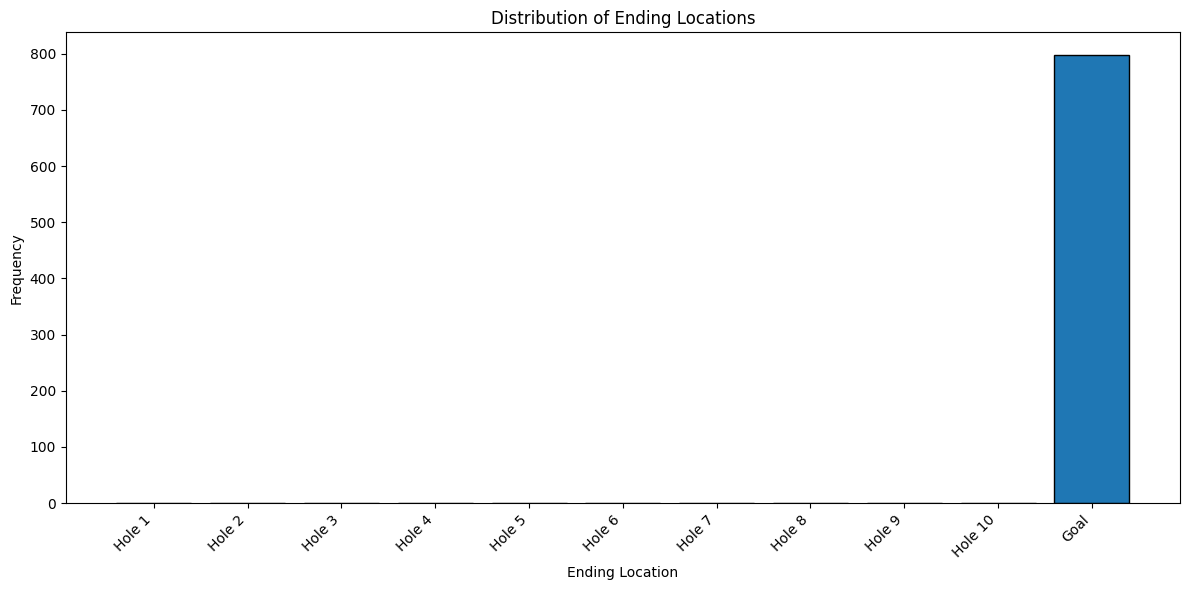

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def run_experiment_with_histogram(policy, env, num_episodes=1000):
    end_locations = []
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            action = policy[obs]
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        end_locations.append(obs)

    # Create a list to store ending locations for histogram
    histogram_data = []

    # Map states to categories (Hole or Goal) with Hole differentiation
    state_categories = {}
    hole_numbers = []
    goal_state = None

    for state in range(env.observation_space.n):
        tile_type = env.unwrapped.desc.flatten()[state].decode("utf-8")
        if tile_type == 'H':
            hole_numbers.append(state)
        elif tile_type == 'G':
            goal_state = state

    state_categories = {state: i + 1 for i, state in enumerate(hole_numbers)}
    if goal_state is not None:
        state_categories[goal_state] = len(hole_numbers) + 1

    for location in end_locations:
        histogram_data.append(state_categories.get(location, -1))

    # Plotting the histogram
    plt.figure(figsize=(12, 6))
    bins = np.arange(0.5, len(hole_numbers) + 2.5, 1)
    plt.hist(histogram_data, bins=bins, align='mid', rwidth=0.8, edgecolor="black")
    plt.xlabel("Ending Location")
    plt.ylabel("Frequency")
    plt.title("Distribution of Ending Locations")

    tick_positions = np.arange(1, len(hole_numbers) + 2, 1)
    tick_labels = [f'Hole {i+1}' for i in range(len(hole_numbers))] + ['Goal']
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

run_experiment_with_histogram(policy, env, num_episodes=1000)